# HuggingFace 커스텀 프로젝트 만들기 [프로젝트]

### 라이브러리 버전을 확인

In [1]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


In [2]:
import torch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

### STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성
- 데이터셋은 깃허브에서 다운받거나, Huggingface datasets에서 가져올 수 있습니다. 앞에서 배운 방법들을 활용해봅시다!

In [6]:
import datasets
from datasets import load_dataset

In [7]:
dataset = load_dataset('nsmc')
print(dataset)

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [8]:
dataset['train'][100]

{'label': 1,
 'id': '10044377',
 'document': '신카이 마코토의 작화와,미유와 하나카나가 연기를 잘해줘서 더대박이였다.'}

### STEP 2. klue/bert-base model 및 tokenizer 불러오기

In [43]:
# del model
# del trainer
# torch.cuda.empty_cache()

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
model.to(device)

## finetuning하지 않았을 때의 성능

In [63]:
# 모델 예측 및 메트릭 계산
model.eval()
all_logits = []
all_labels = []

In [64]:
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        all_logits.append(logits.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

100%|██████████| 1563/1563 [02:44<00:00,  9.51it/s]


In [65]:
# 모든 로짓과 라벨을 하나의 배열로 결합
all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# 메트릭 계산
metrics = compute_metrics((all_logits, all_labels))

print(metrics)

{'accuracy': 0.40602}


### STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기

- 토큰의 갯수를 확인해보기 위해 패딩을 하지 않고 시각화를 해보았고, 시각화 결과에 따라 maxlen을 55로 설정하였다
- bert model의 default값은 256으로 너무 커서 시간이 오래걸리기 때문이다

In [11]:
def tokenize_function(examples):
    encodings = tokenizer(examples['document'], truncation=True, padding=False)
    return encodings

In [12]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

### Train, validation, test dataset 준비

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
def get_token_len(token_list, max_tokens=None, hist=False):
    num_tokens = [len(tokens) for tokens in token_list]
    num_tokens = np.array(num_tokens)

    # 평균값, 최댓값, 표준편차
    print(f"토큰 길이 평균: {np.mean(num_tokens)}")
    print(f"토큰 길이 최소: {np.min(num_tokens)}")
    print(f"토큰 길이 최대: {np.max(num_tokens)}")
    print(f"토큰 길이 표준편차: {np.std(num_tokens)}")
    
    if max_tokens==None:
        max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    print(f'설정 최대 길이: {maxlen}')
    ratio = np.sum(num_tokens < max_tokens) / len(num_tokens) * 100
    print(f'전체 문장의 {round(ratio, 1)}%가 설정값인 {maxlen}에 포함됩니다.')
    
    if hist:
        plt.hist(num_tokens, bins=50)
        plt.axvline(maxlen, color='r', linestyle='dashed', linewidth=1)
        plt.xlabel('length of samples')
        plt.ylabel('number of samples')
        plt.title('Distribution of token lengths')
        plt.show();

토큰 길이 평균: 22.275513333333333
토큰 길이 최소: 2
토큰 길이 최대: 142
토큰 길이 표준편차: 16.69378983543947
설정 최대 길이: 55
전체 문장의 93.5%가 설정값인 55에 포함됩니다.


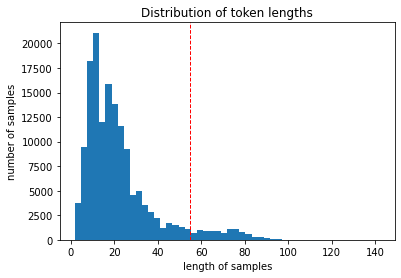

In [15]:
get_token_len(tokenized_datasets['train']['input_ids'], max_tokens=None, hist=True)

토큰 길이 평균: 22.275513333333333
토큰 길이 최소: 2
토큰 길이 최대: 142
토큰 길이 표준편차: 16.69378983543947
설정 최대 길이: 55
전체 문장의 93.5%가 설정값인 55에 포함됩니다.


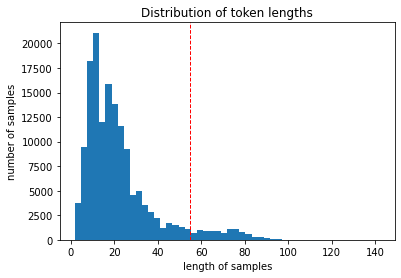

In [16]:
get_token_len(tokenized_datasets['train']['input_ids'], max_tokens=None, hist=True)

In [15]:
maxlen = 55

def tokenize_function_with_max(examples, maxlen=maxlen):
    encodings = tokenizer(examples['document'],max_length=maxlen, truncation=True, padding='max_length')
    return encodings

In [16]:
tokenized_datasets = dataset.map(tokenize_function_with_max, batched=True)

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [17]:
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets["test"]

train_val_dataset = train_dataset.train_test_split(test_size=0.2)

train_dataset = train_val_dataset['train']
val_dataset = train_val_dataset['test']

In [18]:
train_dataset

Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
    num_rows: 120000
})

#### 실험 결과 전체 데이터셋으로 실행하는 경우 9시간이 걸려서 작은 데이터셋으로 먼저 실험을 해보기로 결정했다

In [19]:
small_train_dataset = train_dataset.shuffle(seed=42).select(range(5000))
small_eval_dataset = val_dataset.shuffle(seed=42).select(range(1000))

### model 학습

In [20]:
output_dir = os.getenv('HOME')+'/aiffel/huggingface'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 32,   # 각 device 당 batch size
    per_device_eval_batch_size = 32,    # evaluation 시에 batch size
    num_train_epochs = 2,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [21]:
from datasets import load_metric

# binary classification이고 label이 고르게 나눠져 있다고 한다
metric = load_metric('accuracy')

In [27]:
# !pip install evaluate

In [45]:
# import evaluate

# metric = evaluate.load("accuracy")

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

In [ ]:
trainer.save_model("./my_model_small")

### STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기
- 데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다.

In [ ]:
trainer2 = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer2.train()

In [ ]:
trainer.evaluate(test_dataset)

In [ ]:
trainer2.evaluate(test_dataset)

In [24]:
trainer2.save_model('./my_model_base')

In [59]:
del model
torch.cuda.empty_cache()

In [45]:
model.save_pretrained('./my_model_base')

In [47]:
# # 테스트 데이터셋 준비
# test_dataset = test_dataset.remove_columns(['id', 'document'])  # 필요한 컬럼만 남기기
# test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# # 데이터 로더 생성
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [62]:
# 예측 수행 및 메트릭 계산 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [49]:
from tqdm import tqdm

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
model.to(device)

### STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교
- 아래 링크를 바탕으로 bucketing과 dynamic padding이 무엇인지 알아보고, 이들을 적용하여 model을 학습시킵니다.

    - Data Collator
    - Trainer.TrainingArguments 의 group_by_length

- STEP 4에 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교해보고, 모델 성능 향상과 훈련 시간 두 가지 측면에서 각각 어떤 이점이 있는지 비교해봅시다.

In [66]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

In [34]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
model.to(device)

In [67]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-19a39e6d9a0133be.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

In [68]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 50000
    })
})

In [15]:
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets["test"]

train_val_dataset = train_dataset.train_test_split(test_size=0.2)

train_dataset = train_val_dataset['train']
val_dataset = train_val_dataset['test']

토큰 길이 평균: 22.275513333333333
토큰 길이 최소: 2
토큰 길이 최대: 142
토큰 길이 표준편차: 16.69378983543947
설정 최대 길이: 55
전체 문장의 93.5%가 설정값인 55에 포함됩니다.


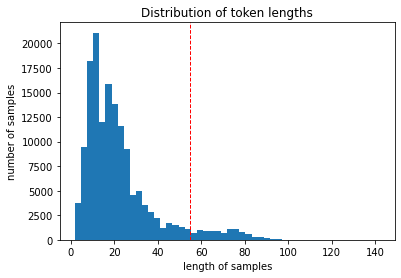

In [20]:
get_token_len(tokenized_datasets['train']['input_ids'], max_tokens=None, hist=True)

In [42]:
del trainer
torch.cuda.empty_cache()

In [43]:
# Data collator with padding for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments with group_by_length enabled
training_args = TrainingArguments(
    output_dir="./dc",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    group_by_length=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 120000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.248300,0.243435,0.902400
2,0.170700,0.260654,0.903633


Saving model checkpoint to ./dc/checkpoint-500
Configuration saved in ./dc/checkpoint-500/config.json
Model weights saved in ./dc/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-1000
Configuration saved in ./dc/checkpoint-1000/config.json
Model weights saved in ./dc/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-1500
Configuration saved in ./dc/checkpoint-1500/config.json
Model weights saved in ./dc/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-2000
Configuration saved in ./dc/checkpoint-2000/config.json
Model weights saved in ./dc/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-2500
Configuration saved in ./dc/checkpoint-2500/config.json
Model weights saved in ./dc/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-3000
Configuration saved in ./dc/checkpoint-3000/config.json
Model weights saved in ./dc/checkpoint-3000/pytorch_model.bin
Saving 

TrainOutput(global_step=7500, training_loss=0.221409912109375, metrics={'train_runtime': 1764.1497, 'train_samples_per_second': 136.043, 'train_steps_per_second': 4.251, 'total_flos': 2893662497967360.0, 'train_loss': 0.221409912109375, 'epoch': 2.0})

- 확실히 training 속도가 엄청 빨라짐을 볼 수 있다

In [44]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 32


{'eval_loss': 0.2583564519882202,
 'eval_accuracy': 0.90442,
 'eval_runtime': 214.9711,
 'eval_samples_per_second': 232.589,
 'eval_steps_per_second': 7.271,
 'epoch': 2.0}

In [45]:
trainer.save_model("./my_model_bucket")

Saving model checkpoint to ./my_model_bucket
Configuration saved in ./my_model_bucket/config.json
Model weights saved in ./my_model_bucket/pytorch_model.bin


In [113]:
import pandas as pd

In [124]:
base_model = {'eval_loss': 0.2689264714717865,
 'eval_accuracy': 0.90304,
 'eval_runtime': 170.5276,
 'eval_samples_per_second': 293.208,
 'eval_steps_per_second': 9.166,
 'epoch': 2.0}

bucket_model = {'eval_loss': 0.44552838802337646,
 'eval_accuracy': 0.90024,
 'eval_runtime': 225.0268,
 'eval_samples_per_second': 222.196,
 'eval_steps_per_second': 6.946,
 'epoch': 2.0}

models = dict()
models['base_model'] = base_model
models['bucket_model'] = bucket_model

In [116]:
pd.DataFrame(models).T

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
base_model,0.268926,0.90304,170.5276,293.208,9.166,2.0
bucket_model,0.445528,0.90024,225.0268,222.196,6.946,2.0


In [117]:
models_train = dict()
models_train['base']={'train_runtime': 2821.7386, 'train_samples_per_second': 85.054, 'train_steps_per_second': 2.658, 'total_flos': 6783331896000000.0, 'train_loss': 0.22245600280761718, 'epoch': 2.0}
models_train['bucket']={'train_runtime': 1684.084, 'train_samples_per_second': 142.511, 'train_steps_per_second': 4.453, 'total_flos': 2893662497967360.0, 'train_loss': 0.07406029764811198, 'epoch': 2.0}

In [118]:
pd.DataFrame(models_train).T

,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,epoch
base,2821.7386,85.054,2.658,6.783332e+15,0.222456,2.0
bucket,1684.0840,142.511,4.453,2.893662e+15,0.074060,2.0


## change params

In [ ]:
# del model
# del trainer
# torch.cuda.empty_cache()

In [96]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
model.to(device)

In [ ]:
# Data collator with padding for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments with group_by_length enabled
training_args = TrainingArguments(
    output_dir="./dc",
    evaluation_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    group_by_length=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 120000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 37500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.083300,0.360882,0.901200
2,0.154600,0.324261,0.903000
3,0.117200,0.335040,0.902833
4,0.110300,0.361037,0.903667
5,0.106300,0.383624,0.903500
6,0.095200,0.390023,0.902500
7,0.087500,0.407823,0.902767
8,0.083500,0.423076,0.902500
9,0.078300,0.430707,0.902633


Saving model checkpoint to ./dc/checkpoint-500
Configuration saved in ./dc/checkpoint-500/config.json
Model weights saved in ./dc/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-1000
Configuration saved in ./dc/checkpoint-1000/config.json
Model weights saved in ./dc/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-1500
Configuration saved in ./dc/checkpoint-1500/config.json
Model weights saved in ./dc/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-2000
Configuration saved in ./dc/checkpoint-2000/config.json
Model weights saved in ./dc/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-2500
Configuration saved in ./dc/checkpoint-2500/config.json
Model weights saved in ./dc/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-3000
Configuration saved in ./dc/checkpoint-3000/config.json
Model weights saved in ./dc/checkpoint-3000/pytorch_model.bin
Saving 

In [69]:
model.save_pretrained('./dc/checkpoint-34000/')

# Data collator with padding for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments with group_by_length enabled
training_args = TrainingArguments(
    output_dir="./dc",
    evaluation_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    group_by_length=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 120000
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3750


Epoch,Training Loss,Validation Loss,Accuracy
1,0.309100,0.305548,0.870633


Saving model checkpoint to ./dc/checkpoint-500
Configuration saved in ./dc/checkpoint-500/config.json
Model weights saved in ./dc/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-1000
Configuration saved in ./dc/checkpoint-1000/config.json
Model weights saved in ./dc/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-1500
Configuration saved in ./dc/checkpoint-1500/config.json
Model weights saved in ./dc/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-2000
Configuration saved in ./dc/checkpoint-2000/config.json
Model weights saved in ./dc/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-2500
Configuration saved in ./dc/checkpoint-2500/config.json
Model weights saved in ./dc/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./dc/checkpoint-3000
Configuration saved in ./dc/checkpoint-3000/config.json
Model weights saved in ./dc/checkpoint-3000/pytorch_model.bin
Saving 

TrainOutput(global_step=3750, training_loss=0.3474164123535156, metrics={'train_runtime': 1393.3961, 'train_samples_per_second': 86.121, 'train_steps_per_second': 2.691, 'total_flos': 3391665948000000.0, 'train_loss': 0.3474164123535156, 'epoch': 1.0})

In [70]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 50000
  Batch size = 32


{'eval_loss': 0.31138962507247925,
 'eval_accuracy': 0.86698,
 'eval_runtime': 166.8412,
 'eval_samples_per_second': 299.686,
 'eval_steps_per_second': 9.368,
 'epoch': 1.0}

In [123]:
models_train['lr_2e6'] = {'train_runtime': 1393.3961, 'train_samples_per_second': 86.121, 'train_steps_per_second': 2.691, 'total_flos': 3391665948000000.0, 'train_loss': 0.3474164123535156, 'epoch': 1.0}

## 원 데이터에서 성능 올리기

In [71]:
tokenized_datasets = dataset.map(tokenize_function_with_max, batched=True)

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-e20a56b80389f406.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

In [72]:
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets["test"]

train_val_dataset = train_dataset.train_test_split(test_size=0.2)

train_dataset = train_val_dataset['train']
val_dataset = train_val_dataset['test']

In [73]:
training_args = TrainingArguments(
    output_dir="./test",
    evaluation_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 120000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.283400,0.274432,0.886833
2,0.261700,0.271819,0.888867


Saving model checkpoint to ./test/checkpoint-500
Configuration saved in ./test/checkpoint-500/config.json
Model weights saved in ./test/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./test/checkpoint-1000
Configuration saved in ./test/checkpoint-1000/config.json
Model weights saved in ./test/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./test/checkpoint-1500
Configuration saved in ./test/checkpoint-1500/config.json
Model weights saved in ./test/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./test/checkpoint-2000
Configuration saved in ./test/checkpoint-2000/config.json
Model weights saved in ./test/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./test/checkpoint-2500
Configuration saved in ./test/checkpoint-2500/config.json
Model weights saved in ./test/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./test/checkpoint-3000
Configuration saved in ./test/checkpoint-3000/config.json
Model weights saved in ./test/check

TrainOutput(global_step=7500, training_loss=0.27669736124674477, metrics={'train_runtime': 2705.9997, 'train_samples_per_second': 88.692, 'train_steps_per_second': 2.772, 'total_flos': 6783331896000000.0, 'train_loss': 0.27669736124674477, 'epoch': 2.0})

In [74]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 32


{'eval_loss': 0.278146356344223,
 'eval_accuracy': 0.88564,
 'eval_runtime': 163.6872,
 'eval_samples_per_second': 305.461,
 'eval_steps_per_second': 9.549,
 'epoch': 2.0}

In [128]:
models['lr_2e6_model'] = {'eval_loss': 0.278146356344223,
 'eval_accuracy': 0.88564,
 'eval_runtime': 163.6872,
 'eval_samples_per_second': 305.461,
 'eval_steps_per_second': 9.549,
 'epoch': 2.0}

In [77]:
del model

In [78]:
torch.cuda.empty_cache()

### 최고 성능을 보여준 모델의 weight을 불러와서 재 학습

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
model.save_pretrained('./my_model_base')
model.to(device)

In [80]:
training_args = TrainingArguments(
    output_dir="./test",
    save_total_limit = 2,
    save_strategy = 'no',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 120000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.257800,0.243454,0.902533
2,0.177800,0.259713,0.903700


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 30000
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 30000
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=7500, training_loss=0.23348990275065104, metrics={'train_runtime': 2560.8193, 'train_samples_per_second': 93.72, 'train_steps_per_second': 2.929, 'total_flos': 6783331896000000.0, 'train_loss': 0.23348990275065104, 'epoch': 2.0})

In [133]:
models_train['base_tr'] = {'train_runtime': 2560.8193, 'train_samples_per_second': 93.72, 'train_steps_per_second': 2.929, 'total_flos': 6783331896000000.0, 'train_loss': 0.23348990275065104, 'epoch': 2.0}

In [81]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 32


{'eval_loss': 0.2575262784957886,
 'eval_accuracy': 0.9041,
 'eval_runtime': 163.2129,
 'eval_samples_per_second': 306.348,
 'eval_steps_per_second': 9.576,
 'epoch': 2.0}

In [135]:
models['base_tr'] = {'eval_loss': 0.2575262784957886,
 'eval_accuracy': 0.9041,
 'eval_runtime': 163.2129,
 'eval_samples_per_second': 306.348,
 'eval_steps_per_second': 9.576,
 'epoch': 2.0}

In [83]:
training_args = TrainingArguments(
    output_dir="./test2",
    save_total_limit = 2,
    save_strategy = 'no',
    evaluation_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.02,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 120000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.089100,0.363316,0.900733
2,0.174200,0.376536,0.899667


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 30000
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 30000
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=7500, training_loss=0.09593519948323567, metrics={'train_runtime': 2553.4695, 'train_samples_per_second': 93.99, 'train_steps_per_second': 2.937, 'total_flos': 6783331896000000.0, 'train_loss': 0.09593519948323567, 'epoch': 2.0})

In [137]:
models_train['base_tr2'] = {'train_runtime': 2553.4695, 'train_samples_per_second': 93.99, 'train_steps_per_second': 2.937, 'total_flos': 6783331896000000.0, 'train_loss': 0.09593519948323567, 'epoch': 2.0}

In [84]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 32


{'eval_loss': 0.372825026512146,
 'eval_accuracy': 0.9001,
 'eval_runtime': 163.4066,
 'eval_samples_per_second': 305.985,
 'eval_steps_per_second': 9.565,
 'epoch': 2.0}

In [138]:
models['base_tr2'] = {'eval_loss': 0.372825026512146,
 'eval_accuracy': 0.9001,
 'eval_runtime': 163.4066,
 'eval_samples_per_second': 305.985,
 'eval_steps_per_second': 9.565,
 'epoch': 2.0}

In [ ]:
import my_token

### huggingface 모델 저장 및 불러오기
- huggingface에 모델 저장

In [140]:
# tokenizer.push_to_hub("klue-base-finetuned-nsmc", use_auth_token=my_token)

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("seongyeon1/klue-base-finetuned-nsmc")
model = AutoModelForSequenceClassification.from_pretrained("seongyeon1/klue-base-finetuned-nsmc")

In [2]:
from transformers import pipeline

pipe = pipeline("text-classification", model="seongyeon1/klue-base-finetuned-nsmc")

In [3]:
pipe("진짜 별로더라")

[{'label': 'LABEL_0', 'score': 0.999700665473938}]

In [4]:
pipe("굿굿")

[{'label': 'LABEL_1', 'score': 0.9875587224960327}]

- 불러와도 잘 동작하는 것을 볼 수 있다

## 모델 테스트 결과 정리

In [151]:
models = pd.DataFrame(models).T

In [155]:
models.index = models.index.str.replace('_model','')

In [156]:
models

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
base,0.268926,0.90304,170.5276,293.208,9.166,2.0
bucket,0.445528,0.90024,225.0268,222.196,6.946,2.0
lr_2e6,0.278146,0.88564,163.6872,305.461,9.549,2.0
base_tr,0.257526,0.90410,163.2129,306.348,9.576,2.0
base_tr2,0.372825,0.90010,163.4066,305.985,9.565,2.0


In [144]:
models_train_df = pd.DataFrame(models_train).T

In [147]:
models_train_df['runtime_per_epoch'] = models_train_df.train_runtime / models_train_df.epoch

In [149]:
models_train_df

,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,epoch,runtime_per_epoch
base,2821.7386,85.054,2.658,6.783332e+15,0.222456,2.0,1410.86930
bucket,1684.0840,142.511,4.453,2.893662e+15,0.074060,2.0,842.04200
lr_2e6,1393.3961,86.121,2.691,3.391666e+15,0.347416,1.0,1393.39610
base_tr,2560.8193,93.720,2.929,6.783332e+15,0.233490,2.0,1280.40965
base_tr2,2553.4695,93.990,2.937,6.783332e+15,0.095935,2.0,1276.73475


In [160]:
results = pd.concat([models.drop('epoch', axis=1),  models_train_df], axis=1)

In [166]:
results.sort_values(by='eval_accuracy', ascending=False)

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,epoch,runtime_per_epoch
base_tr,0.257526,0.90410,163.2129,306.348,9.576,2560.8193,93.720,2.929,6.783332e+15,0.233490,2.0,1280.40965
base,0.268926,0.90304,170.5276,293.208,9.166,2821.7386,85.054,2.658,6.783332e+15,0.222456,2.0,1410.86930
bucket,0.445528,0.90024,225.0268,222.196,6.946,1684.0840,142.511,4.453,2.893662e+15,0.074060,2.0,842.04200
base_tr2,0.372825,0.90010,163.4066,305.985,9.565,2553.4695,93.990,2.937,6.783332e+15,0.095935,2.0,1276.73475
lr_2e6,0.278146,0.88564,163.6872,305.461,9.549,1393.3961,86.121,2.691,3.391666e+15,0.347416,1.0,1393.39610


In [175]:
results.reset_index(inplace=True)

In [176]:
results.sort_values(by='runtime_per_epoch', ascending=True)

,index,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,epoch,runtime_per_epoch
1,bucket,0.445528,0.90024,225.0268,222.196,6.946,1684.0840,142.511,4.453,2.893662e+15,0.074060,2.0,842.04200
4,base_tr2,0.372825,0.90010,163.4066,305.985,9.565,2553.4695,93.990,2.937,6.783332e+15,0.095935,2.0,1276.73475
3,base_tr,0.257526,0.90410,163.2129,306.348,9.576,2560.8193,93.720,2.929,6.783332e+15,0.233490,2.0,1280.40965
2,lr_2e6,0.278146,0.88564,163.6872,305.461,9.549,1393.3961,86.121,2.691,3.391666e+15,0.347416,1.0,1393.39610
0,base,0.268926,0.90304,170.5276,293.208,9.166,2821.7386,85.054,2.658,6.783332e+15,0.222456,2.0,1410.86930


In [202]:
import math

In [211]:
def make_plot(results, col, ascending=True):
    data = results.sort_values(col, ascending=ascending)

    x = data['index']
    y = data[col]
    sns.barplot(x=y, y=x)
    
    min_val = math.floor(data[col].min()* 100) /100
    max_val = math.ceil(data[col].max() * 100) / 100
    
    plt.xlim(min_val, max_val)
    
    for index, value in enumerate(y):
        plt.text(value, index,
                 str(value))

    plt.show();

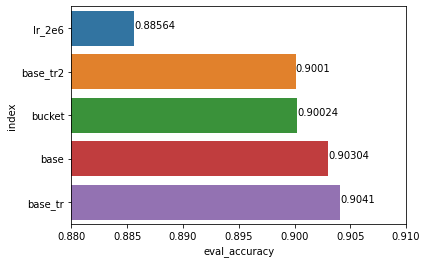

In [214]:
make_plot(results, 'eval_accuracy')

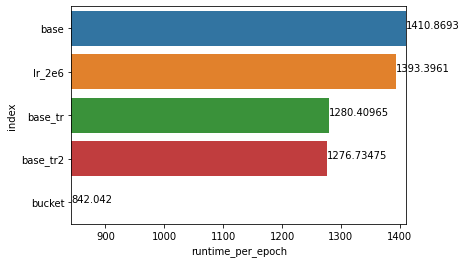

In [215]:
make_plot(results, 'runtime_per_epoch', False)

- bucket을 적용했을 때의 성능이 조금 떨어지는 것을 볼 수 있고
- 학습률을 너무 작게 하면 에폭이 작은 상황이기 때문에 성능이 떨어진다
- 대신 bucket을 적용하면 속도가 상당히 빨라지는 결과를 확인할 수 있었다.

## 회고

---

- 배운 점
    - hugging face 모델을 불러와서 이를 활용해서 task를 수행하는 방법을 배웠다
    - 정확한 실험을 위해서는 모델을 돌릴때마다 모델의 cache를 제거해야한다
    - hugging face에 모델을 load 해서 직접 실험을 해봤는데 재미있었다
- 아쉬운 점
    - parameter에 대해 심도있게 공부해보면 좋겠다는 생각이 들었다
- 느낀 점
    - 공부가 많이 필요하다
- 어려웠던 점
    - customize 하는 것은 언제나 어렵다
    - 성능을 올리는 것은 어려운 과제인 것 같다